                                    Variable  Num_NaNs  Porcentaje
Event Site                        Event Site      1068       90.20
Event                                  Event      1062       89.70
Subtype                              Subtype       212       17.91
Survival Time (years)  Survival Time (years)        32        2.70


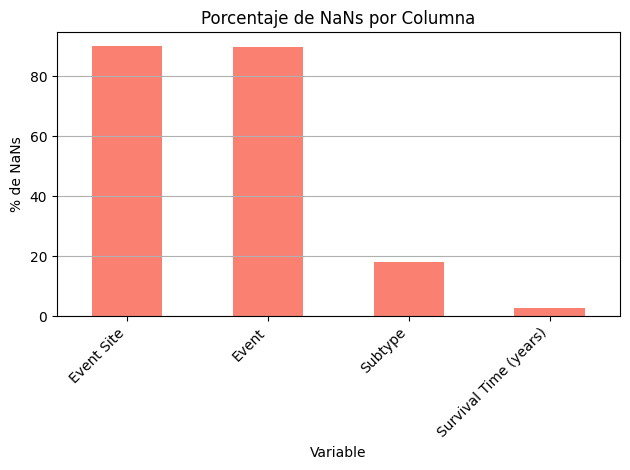

eps=0.3, min_samples=3 -> Silhouette: 0.860 con 71 clusters
eps=0.3, min_samples=5 -> Silhouette: 0.858 con 35 clusters
eps=0.3, min_samples=10 -> Silhouette: 0.858 con 14 clusters
eps=0.4, min_samples=3 -> Silhouette: 0.856 con 75 clusters
eps=0.4, min_samples=5 -> Silhouette: 0.854 con 38 clusters
eps=0.4, min_samples=10 -> Silhouette: 0.856 con 15 clusters
eps=0.5, min_samples=3 -> Silhouette: 0.852 con 79 clusters
eps=0.5, min_samples=5 -> Silhouette: 0.853 con 39 clusters
eps=0.5, min_samples=10 -> Silhouette: 0.856 con 15 clusters
eps=0.6, min_samples=3 -> Silhouette: 0.851 con 79 clusters
eps=0.6, min_samples=5 -> Silhouette: 0.853 con 39 clusters
eps=0.6, min_samples=10 -> Silhouette: 0.856 con 15 clusters

🔝 Mejor configuración: eps=0.3, min_samples=3, Silhouette=0.860


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Cargar datos
data = pd.read_excel('MetaData.xlsx')
df = pd.DataFrame(data)

# Resumen de NaNs
na_summary = pd.DataFrame({
    'Variable': df.columns,
    'Num_NaNs': df.isna().sum(),
    'Porcentaje': (df.isna().mean() * 100).round(2)
})
na_summary = na_summary[na_summary['Num_NaNs'] > 0].sort_values(by='Porcentaje', ascending=False)
print(na_summary)

# Gráfico NaNs
na_summary.plot(kind='bar', x='Variable', y='Porcentaje', legend=False, color='salmon')
plt.title("Porcentaje de NaNs por Columna")
plt.ylabel("% de NaNs")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# Limpiar columnas irrelevantes
df = df.drop(df.columns[[0, -1, 10, 11]], axis=1)

# Eliminar filas con NaN en 'Survival Time (years)'
df = df.dropna(subset=['Survival Time (years)'])

# Definir variables
numeric_vars = ['Age at Diagnosis', 'Survival Time (years)']
categorical_vars = ['Sex', 'Race', 'Definition', 'Menopausal Status', 'Cancer Type',
                    'ER', 'PR', 'HER2', 'Survival Status',
                    'Subtype', 'Genetic Ancestry']

# Pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_vars),
    ('cat', categorical_transformer, categorical_vars)
])

# Preprocesar
X_processed = preprocessor.fit_transform(df)

# PCA para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

# Prueba múltiple de parámetros para DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

def probar_dbscan(X, eps_values=[0.3, 0.4, 0.5, 0.6], min_samples_values=[3, 5, 10]):
    mejores_resultados = []

    for eps in eps_values:
        for min_samples in min_samples_values:
            db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
            labels = db.labels_

            mask = labels != -1
            n_clusters = len(set(labels[mask]))

            if n_clusters > 1:
                score = silhouette_score(X[mask], labels[mask])
                print(f"eps={eps}, min_samples={min_samples} -> Silhouette: {score:.3f} con {n_clusters} clusters")
                mejores_resultados.append((score, eps, min_samples, labels))
            else:
                print(f"eps={eps}, min_samples={min_samples} -> No se forman clusters válidos")

    mejores_resultados.sort(key=lambda x: x[0], reverse=True)

    if mejores_resultados:
        mejor = mejores_resultados[0]
        print(f"\n🔝 Mejor configuración: eps={mejor[1]}, min_samples={mejor[2]}, Silhouette={mejor[0]:.3f}")
        return mejor[3]
    else:
        print("No se encontraron configuraciones con clusters válidos.")
        return None

# Ejecutar prueba de DBSCAN
best_labels = probar_dbscan(X_processed)
####

####

In [ ]:
import pandas as pd

# 1. Carga original (sin eliminar columnas, para conservar todas las que mencionas)
data = pd.read_excel('MetaData.xlsx')
df_full = pd.DataFrame(data)

# 2. Asegúrate que filas y orden coinciden con las de df que procesaste para clustering
# Si eliminaste filas con NaN en 'Survival Time (years)', filtra igual aquí:
df_full = df_full.dropna(subset=['Survival Time (years)'])

# 3. Añade la columna cluster_id (las etiquetas que resultaron del clustering)
if best_labels is not None:
    df_full['cluster_id'] = best_labels

    # 4. Reordena columnas para que queden como en tu formato deseado
    columnas_deseadas = [
        'cluster_id', 'paciente_id', 'Patient ID', 'Age at Diagnosis', 'Sex', 'Race',
        'Definition', 'Menopausal Status', 'Cancer Type', 'ER', 'PR', 'HER2', 'Event',
        'Event Site', 'Survival Status', 'Survival Time (years)', 'Subtype',
        'Genetic Ancestry', 'hidden'
    ]

    # Filtra solo columnas disponibles para evitar errores por columnas que falten
    columnas_existentes = [col for col in columnas_deseadas if col in df_full.columns]

    df_final = df_full[columnas_existentes]

    # 5. Guardar a Excel para análisis externo
    df_final.to_excel('MetaData_con_cluster_id_15clusters.xlsx', index=False)

    print("Archivo con cluster_id generado y guardado como 'MetaData_con_cluster_id.xlsx'")
    print(df_final.head(5))


In [ ]:
## obtener un modelo con parametros espeecificos, en este caso un modelo con 14 clusters como resultado
import pandas as pd
from sklearn.cluster import DBSCAN

# Carga el dataset original completo (sin eliminar columnas)
df_full = pd.read_excel('MetaData.xlsx')

# Aplica filtro para que coincida con el dataset que usaste para clustering (por ejemplo, filas sin NaN en 'Survival Time (years)')
df_full = df_full.dropna(subset=['Survival Time (years)']).reset_index(drop=True)

# Supongamos que tienes tus datos procesados para clustering en X_processed
# y ya sabes que estos parámetros generan 14 clusters:
db_14clusters = DBSCAN(eps=0.3, min_samples=10).fit(X_processed)
labels_14 = db_14clusters.labels_

# Verifica que son 14 clusters (excluyendo ruido)
n_clusters_14 = len(set(labels_14) - {-1})
print(f"Número de clusters formados: {n_clusters_14}")

if n_clusters_14 == 14:
    # Añade la etiqueta cluster_id al df completo
    df_full['cluster_id'] = labels_14

    # Define las columnas que quieres conservar y en qué orden
    columnas_deseadas = [
        'cluster_id', 'paciente_id', 'Patient ID', 'Age at Diagnosis', 'Sex', 'Race',
        'Definition', 'Menopausal Status', 'Cancer Type', 'ER', 'PR', 'HER2', 'Event',
        'Event Site', 'Survival Status', 'Survival Time (years)', 'Subtype',
        'Genetic Ancestry', 'hidden'
    ]

    # Filtra solo las columnas que existan en el DataFrame para evitar errores
    columnas_existentes = [col for col in columnas_deseadas if col in df_full.columns]

    df_final = df_full[columnas_existentes]

    # Guarda el resultado a Excel
    df_final.to_excel('MetaData_con_cluster_id_14clusters.xlsx', index=False)
    print("Archivo guardado como 'MetaData_con_cluster_id_14clusters.xlsx'")
else:
    print("No se formaron 14 clusters con los parámetros indicados")


Número de clusters formados: 14
Archivo guardado como 'MetaData_con_cluster_id_14clusters.xlsx'


In [ ]:
cluster_counts = df['Cluster'].value_counts(normalize=True).sort_index() * 100

plt.figure(figsize=(6,4))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title('Proporción de cada Clúster (%)')
plt.xlabel('Cluster')
plt.ylabel('Porcentaje')
plt.ylim(0, 100)
for i, v in enumerate(cluster_counts.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')
plt.show()
for col in categorical_vars:
    plt.figure(figsize=(8,5))
    sns.countplot(data=df, x=col, hue='Cluster', palette='viridis',
                  order=df[col].value_counts().index)
    plt.title(f'Distribución de {col} por Cluster')
    plt.xticks(rotation=45)
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()


KeyError: 'Cluster'

In [ ]:
for col in categorical_vars:
    prop_table = pd.crosstab(df['Cluster'], df[col], normalize='index') * 100
    print(f"\nProporción (%) de {col} por Cluster:")
    print(prop_table.round(2))


In [ ]:

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Crear un DataFrame con la información necesaria
df_surv = df[['Survival Time (years)', 'Survival Status']].copy()
df_surv['event'] = df_surv['Survival Status'].map({'Alive': 0, 'Dead': 1})

# Asegúrate que los índices coincidan
df_surv = df_surv.reset_index(drop=True)
df_surv['cluster'] = best_labels  # Agregar las etiquetas de clúster

# Filtrar datos sin ruido
df_valid = df_surv[df_surv['cluster'] != -1]

# Graficar curvas de supervivencia por cluster
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

for cluster_id in sorted(df_valid['cluster'].unique()):
    grupo = df_valid[df_valid['cluster'] == cluster_id]
    kmf.fit(grupo['Survival Time (years)'], label=f'Cluster {cluster_id}')
    kmf.plot(ci_show=True)

plt.title("Curvas de Supervivencia por Cluster (Kaplan-Meier)")
plt.xlabel("Tiempo de Supervivencia (años)")
plt.ylabel("Probabilidad de Supervivencia")
plt.grid(True)
plt.tight_layout()
plt.show()
